# ResNet Ablation Study

## 1. CIFAR-10 데이터셋 준비하기¶

In [2]:
# TensorFlow and of.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()    # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10', 
    split=['train', 'test'], 
    shuffle_files=True, 
    with_info=True,
)

Metal device set to: Apple M1


2021-09-27 14:20:22.990438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-27 14:20:22.990564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### Input Normalization

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `unit8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

2021-09-27 14:20:23.082486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-27 14:20:23.082813: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-27 14:20:23.100970: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


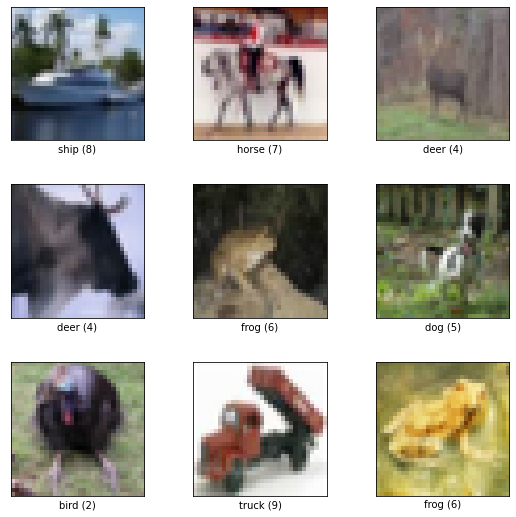

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

2021-09-27 14:20:23.318215: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


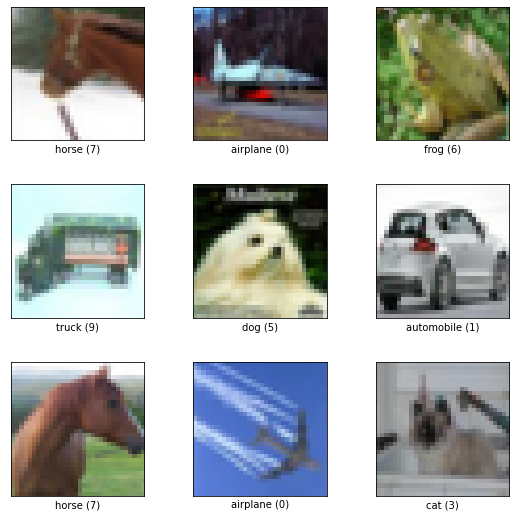

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. 블록 구성하기

### ResNet 기본 블록 만들기

In [49]:
# function for building VGG Block

def build_resnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1, 
                       is_50=False):

    # 입력 레이어
    x = input_layer

    if is_50==False:
        for i in range(num_cnn):
            if num_cnn == 0 and block_num > 0:
                shortcut = keras.layers.conv2D(filters=channel, 
                                               kernel_size=(3,3), 
                                               kernel_initializer='he_normal', 
                                               padding='same', 
                                               strides=2)(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        strides=2,
                                        name=f'stage_{block_num+2}_{num_cnn+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{num_cnn+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{num_cnn+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{num_cnn+1}_2')(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
                
            else:
                shortcut = x
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{num_cnn+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{num_cnn+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{num_cnn+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{num_cnn+1}_2')(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)

    return x

In [45]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    output = input_layer
    output = keras.layers.Conv2D(64, (7,7), kernel_initializer='he_normal', padding='same', strides=2, name='conv2d_15')(output)
    output = keras.layers.BatchNormalization(name='batch_normalization_13')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn, 
                                    channel=channel,
                                    block_num=i, 
                                    is_50=is_50)
        
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(activation='relu', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, 
                        outputs=output)
    
    return model

## 3. ResNet Complete Model

### ResNet-34

In [50]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

ValueError: Operands could not be broadcast together with shapes (8, 8, 128) (8, 8, 64)

### ResNet-50

In [95]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_799 (Conv2D)             (None, 16, 16, 64)   9472        input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_759 (BatchN (None, 16, 16, 64)   256         conv2d_799[0][0]                 
__________________________________________________________________________________________________
activation_568 (Activation)     (None, 16, 16, 64)   0           batch_normalization_759[0][0]    
___________________________________________________________________________________________